In [1]:
import re
from wordcloud import WordCloud
import pandas as pd
from flask import request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from
from flask import Flask, jsonify
import sqlite3
import demoji
import emoji
from unidecode import unidecode
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

# 2. LSTM

In [2]:
df_lstm = pd.read_csv('platinum/train_preprocess.tsv.txt', sep='\t', header=None, names=['text', 'label'], quoting=3)

In [3]:
df_lstm.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df_lstm.shape

(11000, 2)

In [5]:
df_lstm.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

## Text Normalization/Cleansing

In [6]:
import re

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [7]:
df_lstm['text_clean'] = df_lstm.text.apply(cleansing)

In [8]:
df_lstm.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


Sortir data dan label berdasarkan sentimenm

In [9]:
neg = df_lstm.loc[df_lstm['label'] == 'negative'].text_clean.tolist()
neu = df_lstm.loc[df_lstm['label'] == 'neutral'].text_clean.tolist()
pos = df_lstm.loc[df_lstm['label'] == 'positive'].text_clean.tolist()

neg_label = df_lstm.loc[df_lstm['label'] == 'negative'].label.tolist()
neu_label = df_lstm.loc[df_lstm['label'] == 'neutral'].label.tolist()
pos_label = df_lstm.loc[df_lstm['label'] == 'positive'].label.tolist()

In [10]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


## Feature Extraction

In [11]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('platinum/resources_of_lstm/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('platinum/resources_of_lstm/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")


tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [13]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('platinum/resources_of_lstm/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Prepare train & test datasets/Splitting Dataset

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [14]:
from sklearn.model_selection import train_test_split

file = open("platinum/resources_of_lstm/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("platinum/resources_of_lstm/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### Training

In [15]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [16]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10



880/880 [==============================] - 116s 129ms/step - loss: 0.4518 - accuracy: 0.8247 - val_loss: 0.3592 - val_accuracy: 0.8686
Epoch 2/10
880/880 [==============================] - 131s 148ms/step - loss: 0.2018 - accuracy: 0.9259 - val_loss: 0.3589 - val_accuracy: 0.8714
Epoch 3/10
880/880 [==============================] - 129s 146ms/step - loss: 0.1078 - accuracy: 0.9594 - val_loss: 0.3929 - val_accuracy: 0.8736
Epoch 3: early stopping


## Evaluation

 Confussion Matrix, Accuracy, F1, Recall, Precision

In [17]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 10ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       685
           1       0.82      0.78      0.80       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.84      0.85      2200
weighted avg       0.87      0.87      0.87      2200



## Cross Validation

In [18]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 9ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       685
           1       0.85      0.76      0.81       233
           2       0.93      0.90      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.88      0.88      0.88      2200



69/69 [==============================] - 1s 9ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       685
           1       0.81      0.79      0.80       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 11ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       685
           1       0.88      0.69      0.77       233
           2       0.90      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.86      0.81      0.83      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 11ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       685
           1       0.87      0.77      0.82       233
           2       0.89      0.93      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.84      0.85      2200
weighted avg       0.88      0.88      0.87      2200



69/69 [==============================] - 1s 10ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.89      0.72      0.79       685
           1       0.84      0.80      0.82       233
           2       0.86      0.96      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.87      0.87      0.86      2200




Rata-rata Accuracy:  0.8716363636363635


## Visualisation

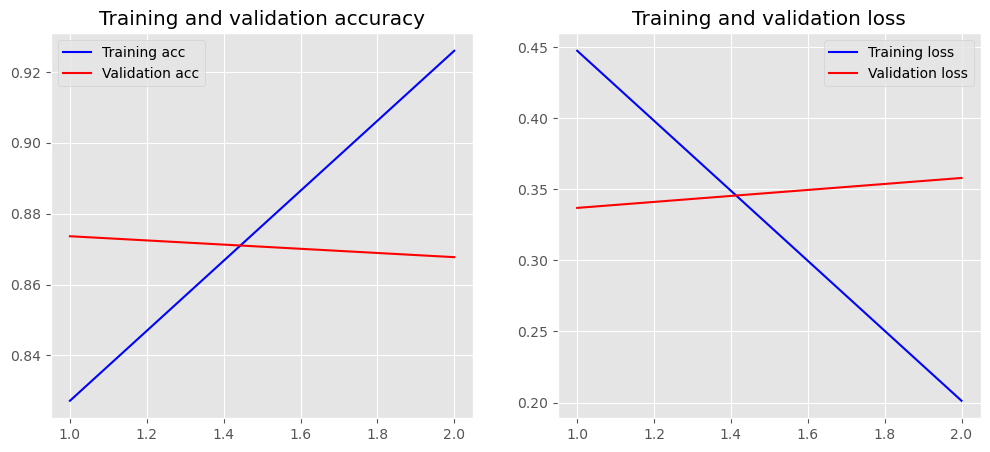

In [19]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [20]:
model.save('platinum/model_of_lstm/model.h5')
print("Model has created!")

C:\Users\akung\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


## Predict

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_features = 100000
tokenizer = Tokenizer (num_words=max_features, split = ' ', lower = True)
sentiment = ['negative', 'neutral','positive']

In [22]:
file = open('platinum/resources_of_lstm/x_pad_sequences.pickle', 'rb')
feature_file_from_lstm = pickle.load(file)
file.close()

In [24]:
from tensorflow.keras.models import load_model

model_file_from_lstm = load_model ('platinum/model_of_lstm/model.h5')

In [26]:
import re
from keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
import numpy as np

input_text = """
kamu terlihat baik.
"""

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']
tokenizer = Tokenizer()

text = [cleansing(input_text)]
tokenizer.fit_on_texts(text)
feature = tokenizer.texts_to_sequences(text)

feature = pad_sequences(feature, maxlen=feature_file_from_lstm.shape[1])

prediction = model_file_from_lstm.predict(feature)
get_sentiment = sentiment[np.argmax(prediction[0])]

print("Text: ", text[0])
print("Sentiment: ", get_sentiment)


1/1 [==============================] - 0s 75ms/step
Text:   kamu terlihat baik  
Sentiment:  positive
